### Problem 3

$$
z_{i,j} = \beta_0 + \mu_i + \eta_j + \epsilon_{i,j}
$$
$$
\mu_i\sim\mathcal{N}(0, \sigma_1^2)
$$
$$
\eta_j\sim\mathcal{N}(0, \sigma_2^2)
$$
$$
\epsilon_{i,j}\sim\mathcal{N}(0, \sigma_{\epsilon}^2)
$$

#### Sol:

Matrix Form:
$$
\bf{z} = \bf {e}\beta_0 + X\mu + Y\eta + \epsilon
$$
Under the assumed prior, the posterior is given by:
$$
{\bf z} | \beta_0, \sigma_1^2, \sigma_2^2, \sigma_\epsilon^2 \sim \mathcal{N}({\bf e}\beta_0, {\bf YY^T}\sigma_2^2+{\bf XX^T}\sigma_1^2+\sigma_\epsilon^2{\bf I})
$$
Loglikelihood:
$$
{\bf LL}(\beta_0, \sigma_1^2, \sigma_2^2, \sigma_\epsilon^2)
=-\frac{1}{2}\left(
\ln |{\bf YY^T}\sigma_2^2+{\bf XX^T}\sigma_1^2+\sigma_\epsilon^2{\bf I}| + ({\bf z} - {\bf e}\beta_0)^T|{\bf YY^T}\sigma_2^2+{\bf XX^T}\sigma_1^2+\sigma_\epsilon^2{\bf I}|^{-1} ({\bf z} - {\bf e}\beta_0) + n\ln 2\pi
\right)
$$
where $n=I\times J$.Denote $K(\sigma_1^2, \sigma_2^2) = {\bf YY^T}\sigma_2^2+{\bf XX^T}\sigma_1^2$

Denote ${\bf K}(\sigma_1^2, \sigma_2^2) = {\bf YY^T}\sigma_2^2+{\bf XX^T}\sigma_1^2$, then 
$$
{\bf LL}(\beta_0, \sigma_1^2, \sigma_2^2, \sigma_\epsilon^2)
=-\frac{1}{2}\left(
\ln |{\bf K} + \sigma_\epsilon^2 {\bf I}| +({\bf z} - {\bf e}\beta_0)^T|{\bf K}+\sigma_\epsilon^2{\bf I}|^{-1} ({\bf z} - {\bf e}\beta_0) + N\ln 2\pi
\right)
$$

Follow the Lecture notes, we decompose matrix $\bf K=USU^T $. Then refering to the lecture notes Page 20, we obtain 
$$
\hat{\beta} = \left[\sum_{n=1}^N \frac{1}{S_{ii} + \sigma_\epsilon^2} (U^T e)_i^2\right]^{-1}
\left[\sum_{n=1}^N \frac{1}{S_{ii} + \sigma_\epsilon^2} (U^T e)_i(U^T z)_i\right]
$$
Note that $\bf U$ and $\bf S$ are functions of $(\sigma_1^2, \sigma_2^2)$.

Substituting $\hat{\beta}$ into the $\bf LL$ and take the partial derivative w.r.t. $\sigma_1^2$ and $\sigma_2^2$ respectively:

I cannot go further...

#### We can use EM algorithm to solve it!

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
df = pd.read_csv("../data/score.txt", delimiter=' ')

In [9]:
df

,score,school,subject
0,72.9,1,1
1,72.6,1,1
2,72.2,1,1
3,74.9,1,1
4,74.9,1,1
...,...,...,...
2995,75.9,30,15
2996,67.3,30,15
2997,69.2,30,15
2998,70.9,30,15


In [21]:
X1 = pd.get_dummies(df.school).values
X2 = pd.get_dummies(df.subject).values
y = df.score.values-73.222

In [12]:
class VCM3:
    '''
    three-variance-component model
    '''
    def __init__(self, X1, X2, y):
        self.X1 = X1
        self.X2 = X2
        self.X = np.concatenate((X1, X2), axis=1)
        self.y = y 
        self.p1 = X1.shape[1]
        self.p2 = X2.shape[1]
        self.n = y.shape[0]
        
    def mu_1_sigma_1(self, a, b, c):
        p1 = self.p1
        n = self.n
        X1 = self.X1
        X2 = self.X2
        y = self.y
        
        sigma_1 = np.linalg.inv(a*np.identity(p1) + X1.T@np.linalg.inv(X2@X2.T/b+np.identity(n)/c)@X1)
        mu_1 = sigma_1@X1.T@np.linalg.inv(X2@X2.T/b+np.identity(n)/c) @y
        
        return mu_1, sigma_1
    
    def mu_2_sigma_2(self, a, b, c):
        p2 = self.p2
        n = self.n
        X1 = self.X1
        X2 = self.X2
        y = self.y
        
        sigma_2 = np.linalg.inv(b*np.identity(p2) + X2.T@np.linalg.inv(X1@X1.T/a+np.identity(n)/c)@X2)
        mu_2 = sigma_2@X2.T@np.linalg.inv(X1@X1.T/a+np.identity(n)/c) @y
        
        return mu_2, sigma_2
    
    def mu_r_sigma_r(self, a, b, c):
        p1 = self.p1
        p2 = self.p2
        n = self.n
        X1 = self.X1
        X2 = self.X2
        X = self.X
        y = self.y  
        
        A = a*np.identity(p1) + c*X1.T@X1
        B = c*X1.T@X2
        C = c*X2.T@X1
        D = b*np.identity(p2) + c*X2.T@X2
        
        sigma_r = np.linalg.inv(\
                    np.concatenate((np.concatenate((A, B), axis=1), \
                                    np.concatenate((C, D), axis=1)), \
                                   axis=0))
        mu_r = c*sigma_r@X.T@y
        
        return mu_r, sigma_r
    
    def llh(self, a, b, c):
        p1 = self.p1
        p2 = self.p2
        n = self.n
        X1 = self.X1
        X2 = self.X2
        X = self.X
        y = self.y  
        
        tmp = np.identity(n)/c + X1@X1.T/a + X2@X2.T/b 
        sign, logdet = np.linalg.slogdet(tmp)
        
        t = logdet + y.T@np.linalg.inv(tmp)@y + n*np.log(2*np.pi)
        return -1/2*t    
    
    def solve(self, time_step, a0, b0, c0, tol=1e-6):
        p1 = self.p1
        p2 = self.p2
        n = self.n
        X = self.X
        y = self.y
        
        llhs = []
        llhs.append(self.llh(a0, b0, c0))
        a, b, c = a0, b0, c0
        for t in range(time_step):
            mu_1, sigma_1 = self.mu_1_sigma_1(a, b, c)
            mu_2, sigma_2 = self.mu_2_sigma_2(a, b, c)
            mu_r, sigma_r = self.mu_r_sigma_r(a, b, c)
            a = p1/(mu_1.T@mu_1 + np.trace(sigma_1))
            b = p2/(mu_2.T@mu_2 + np.trace(sigma_2))
            c = n/(np.linalg.norm(y-X@mu_r)**2 + np.trace(X.T@X@sigma_r))

            llhs.append(self.llh(a, b, c))
            if llhs[-1]-llhs[-2] < tol:
                break
        return a, b, c, llhs

In [22]:
model = VCM3(X1, X2, y)
a, b, c, lhs = model.solve(2000000, 1, 1, 1)

(22.787646090885247, 34.08280400732777, 9.841616354246375)

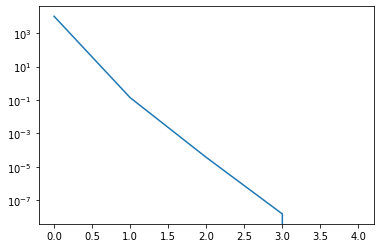

In [23]:
plt.plot(max(lhs)-lhs)
plt.yscale('log')
1/a, 1/b, 1/c